In [30]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sb
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [31]:
# Data loading and prep 
df = pd.read_csv("./data/marriage.csv", header=None)
#print(df.head())

data = np.asarray(df)
labels = data[:, -1]
data = data[:, :-1]
m, n = data.shape

print(data.shape, labels.shape)

# project data to 2 dimensions 
pca = PCA(n_components=2)
data_red = pca.fit(data).transform(data)
#print(X_red.shape)

(170, 54) (170,)


In [34]:
# Naive Bayes, Logistic Regression, and kNN on full data

# USE AS TOGGLE BETWEEN FULL AND PROJECTED DATA
X = data_red # data

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size= 0.2, shuffle=True)
#print(Xtrain)

X_train_var = np.var(X_train, axis=0)
#print(Xtrain.shape, Xtrain_var.shape)

# ensure variance is not less than 1e-3
X_train_var = np.where(X_train_var < 1e-3, 1e-3, X_train_var)

# Naive Bayes
NB = GaussianNB().fit(X_train, y_train)
NB_pred = NB.predict(X_test)
print((y_test == NB_pred).sum() / X_test.shape[0])

# Logistic Regression 
logit = LogisticRegression(solver='liblinear').fit(X_train, y_train)
logit_pred = logit.predict(X_test)
print((y_test == logit_pred).sum() / X_test.shape[0])

# kNN
kNN = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
kNN_pred = kNN.predict(X_test)
print((y_test == kNN_pred).sum() / X_test.shape[0])


0.9705882352941176
0.9705882352941176
1.0


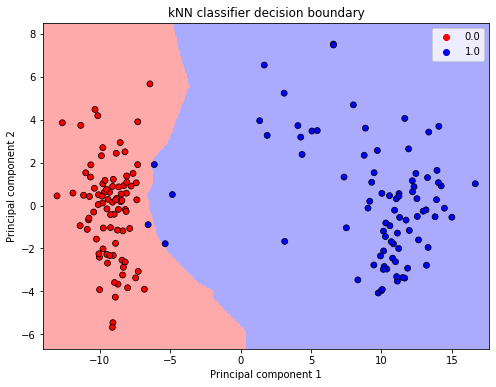

In [36]:
step = .1 

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ['r', 'b']

x_min, x_max = data_red[:, 0].min() - 1, data_red[:, 0].max() + 1
y_min, y_max = data_red[:, 1].min() - 1, data_red[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# TOGGLE FOR WHICH CLASSIFIER TO USE 
# NB, logit, or kNN
pred = kNN.predict(np.c_[xx.ravel(), yy.ravel()])

pred = pred.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred, cmap=cmap_light)

# plot points
sb.scatterplot(x=data_red[:, 0], y=data_red[:, 1], hue=labels,
                palette=cmap_bold, alpha=1.0, edgecolor="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# change title
plt.title("kNN classifier decision boundary")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.show()

In [38]:
# Part 2
# NOTE: I am resusing X_train nomenclature for simplicity which will overwrite the previous part

path = "./data/mnist_10digits.mat"

images = sp.io.loadmat(path)
X_train = images['xtrain'] / 255
y_train = images['ytrain'].reshape(-1)
X_test = images['xtest'] / 255
y_test = images['ytest'].reshape(-1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [77]:
# kNN cross validation

# CV
for k in range(1, 61, 5): #range(1, 6)
    kNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    kNN_pred = kNN.predict(X_test)
    print((y_test == kNN_pred).sum() / X_test.shape[0])


0.9691
0.9627
0.9705
0.9682
0.9688


In [40]:
# A simple function that takes the classifier/model of choice with model params as parameters and visualizes metrics 

def classifier(X_train, y_train, X_test, y_test, model, **model_params):
    model = model(**model_params).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    conf_mat = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(conf_mat)
    display(cm.style.set_caption("Confusion matrix for %s" % (model)))
    
    prec = [] 
    recall = [] 
    f1 = []
    for i in range(0, 10):
        tp = conf_mat[i, i]
        fp = np.sum(conf_mat[:, i]) - tp
        fn = np.sum(conf_mat[i, :]) - tp
        #print(tp, fp, fn)
        prec.append(tp / (tp+fp))
        recall.append(tp / (tp+fn))
        f1.append((2*prec[i]*recall[i]) / (prec[i]+recall[i]))
        
    metrics_dict = {'Precision':prec, 'Recall':recall, 'F1 Score':f1}
    metrics_df = pd.DataFrame(metrics_dict)
    display(metrics_df)
    
#classifier(X_train, y_train, X_test, y_test, KNeighborsClassifier, n_neighbors=3)
#classifier(X_train, y_train, X_test, y_test, LogisticRegression, solver='saga', max_iter=200)
#classifier(X_train, y_train, X_test, y_test, SVC, kernel='linear')
classifier(X_train, y_train, X_test, y_test, SVC, kernel= 'rbf', gamma=0.001)
#classifier(X_train, y_train, X_test, y_test, MLPClassifier, hidden_layer_sizes=(20, 10), random_state=1)

,0,1,2,3,4,5,6,7,8,9
0,967,0,2,0,0,5,4,1,1,0
1,0,1119,2,3,0,1,3,1,6,0
2,10,1,953,9,11,1,13,11,21,2
3,1,1,15,948,1,17,1,10,12,4
4,1,2,7,0,935,0,7,2,2,26
5,7,5,5,32,8,808,11,2,9,5
6,9,3,4,1,6,11,923,0,1,0
7,2,13,22,5,8,1,0,953,4,20
8,4,7,7,14,8,24,10,7,890,3
9,8,6,0,12,34,6,1,15,6,921


,Precision,Recall,F1 Score
0,0.958375,0.986735,0.972348
1,0.967156,0.985903,0.976440
2,0.937070,0.923450,0.930210
3,0.925781,0.938614,0.932153
4,0.924827,0.952138,0.938284
5,0.924485,0.905830,0.915062
6,0.948613,0.963466,0.955981
7,0.951098,0.927043,0.938916
8,0.934874,0.913758,0.924195
9,0.938838,0.912785,0.925628


Tried CV using k = range(1, 61, 5) and used accuracy as a metric and observed a steady monotonic decrease with increasing k. 
0.9691
0.9677
0.9668
0.9632
0.963
0.9612
0.9591
0.9578
0.9564
0.9543
0.9533
0.9523 
So I decided to try k = range(1, 6)
0.9691
0.9627
0.9705
0.9682
0.9688